In [8]:
import os
import sys
import glob

import warnings
warnings.filterwarnings('ignore') # Some things we'll be doing throw runtimewarnings that we won't care about. 

from astropy.io import fits
from astropy.wcs import WCS
import astropy.constants as const
import astropy.units as u
from astropy.visualization import astropy_mpl_style

import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import matplotlib

### This is magic for Jupyer Notebooks. 
### Delete if putting into a script!
%matplotlib inline 
#######################################

import imageio 

In [37]:

galaxy = 'HE0045-2145'#MUSE/HE0150-0344/
cars_data_directory = 'MUSE/'+str(galaxy)+'/'
os.listdir(cars_data_directory)

['HE0045-2145_FOV_SDSSr.fits',
 'HE0045-2145_FOV_SDSSg.fits',
 'HE0045-2145.stellar_table.fits',
 '.DS_Store',
 'fitting',
 'images',
 'HE0045-2145grimap.png',
 'HE0045-2145.eline_table.fits',
 'HE0045-2145.kin_table.fits',
 'HE0045-2145_FOV_SDSSi.fits',
 'HE0045-2145.unbinned.fits.gz',
 'HE0045-2145.unbinned.fits']

In [4]:
z = 0.04787 # The redshift, which I just grabbed from NED. Doesn't need to be too exact for our purposes.  
cz = z * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

In [46]:
fov = cars_data_directory + str(galaxy)+'_FOV_SDSSr.fits'

In [47]:
hdu = fits.open(fov) # Open the .fits file, return a list of Header/Data Units (HDUs). 
hdu.info()

Filename: MUSE/HE0045-2145/HE0045-2145_FOV_SDSSr.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  DATA          1 PrimaryHDU      43   (319, 314)   float32   


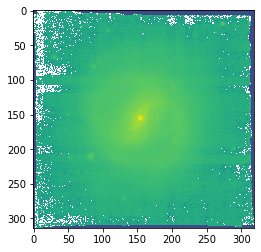

In [48]:
hdr = hdu[0].header
fovdata = hdu[0].data


plt.clf()
plt.imshow(fovdata, norm=matplotlib.colors.LogNorm())
plt.show()

dim = hdu[0].data.shape
hdu.close() # We no longer need this, so let's close it. We're effectively getting rid of a memory map. 



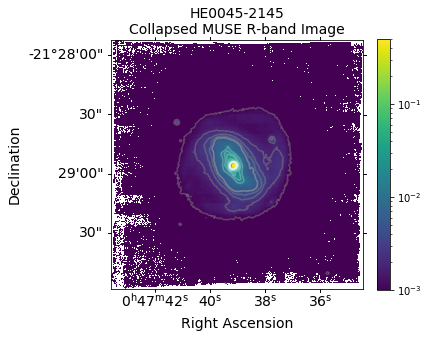

In [63]:
wcs = WCS(hdr,  naxis=2)

fontsize=14


fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection=wcs)

ax.coords[0].set_axislabel('Right Ascension', fontsize=fontsize)
ax.coords[1].set_axislabel('Declination', fontsize=fontsize)

fovdata[fovdata == 0] = np.nan 
# Reprojection pads the background (where there is no data) with zeroes. 
# This is a problem, because Zero will be mapped to a color in our cmap. We don't want a colored background!
# So, in the line above, I force the background to be a NaN. 

cmap=cm.viridis # Always pick good, perceptually uniform color maps!
cmap.set_bad('white',1) # We set NaNs to be white here. 

ax.set_title(str(galaxy)+'\nCollapsed MUSE R-band Image', fontsize=fontsize)

ax.tick_params(labelsize=14)

frame = ax.imshow(fovdata, origin='lower', norm=LogNorm(), vmin=0.001, vmax=0.5, cmap=cmap, interpolation='None')
plt.colorbar(frame, fraction=0.045)
ax.contour(fovdata, levels=np.linspace(5e-3,1e-1, 15), colors='white', alpha=0.25)
ax.contour(fovdata, levels=np.linspace(1e-3,5e-3, 5), colors='gray', alpha=0.5)

plt.show()

In [27]:
# 
print(np.linspace(1e-3,1e-1,3))
print(np.linspace(1e-3,3e-1, 10))

[0.001  0.0505 0.1   ]
[0.001      0.03422222 0.06744444 0.10066667 0.13388889 0.16711111
 0.20033333 0.23355556 0.26677778 0.3       ]


### Now try to get the emission line ratios
(using the one Gaussian fit from the CARs data output)

In [50]:
gas = cars_data_directory + str(galaxy)+'.eline_table.fits' # The UNBINNED Gas kinematics Table

In [51]:
# Read in the emission line table, from which we'll make gas maps
eline_hdu = fits.open(gas)
eline_tab = eline_hdu[1].data

eline_columns = eline_hdu[1].header
print(eline_columns)

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  344 / length of dimension 1                          NAXIS2  =                94671 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                   86 / number of table fields                         TTYPE1  = 'x_cor   '                                                            TFORM1  = 'J       '                                                            TTYPE2  = 'y_cor   '                                                            TFORM2  = 'J       '                                                            TTYPE3  = 'Halpha_flux'                 

In [154]:
eline_x_cor = eline_tab.field('x_cor')
eline_y_cor = eline_tab.field('y_cor')

In [155]:
Ha_flux = eline_tab.field('Halpha_flux')
Ha_flux_err = eline_tab.field('Halpha_flux_err')
Ha_vel = eline_tab.field('Halpha_vel')
Ha_vel_err = eline_tab.field('Halpha_vel_err')
Ha_fwhm = eline_tab.field('Halpha_fwhm')
Ha_fwhm_err = eline_tab.field('Halpha_fwhm_err')

In [156]:
Hb_flux = eline_tab.field('Hbeta_flux')
Hb_flux_err = eline_tab.field('Hbeta_flux_err')
Hb_vel = eline_tab.field('Hbeta_vel')
Hb_vel_err = eline_tab.field('Hbeta_vel_err')
Hb_fwhm = eline_tab.field('Hbeta_fwhm')
Hb_fwhm_err = eline_tab.field('Hbeta_fwhm_err')

In [157]:
OIII5007_flux = eline_tab.field('OIII5007_flux')
OIII5007_flux_err = eline_tab.field('OIII5007_flux_err')
OIII5007_vel = eline_tab.field('OIII5007_vel')
OIII5007_vel_err = eline_tab.field('OIII5007_vel_err')
OIII5007_fwhm = eline_tab.field('OIII5007_fwhm')
OIII5007_fwhm_err = eline_tab.field('OIII5007_fwhm_err')

In [158]:
NII6583_flux = eline_tab.field('NII6583_flux')
NII6583_flux_err = eline_tab.field('NII6583_flux_err')
NII6583_vel = eline_tab.field('NII6583_vel')
NII6583_vel_err = eline_tab.field('NII6583_vel_err')
NII6583_fwhm = eline_tab.field('NII6583_fwhm')
NII6583_fwhm_err = eline_tab.field('NII6583_fwhm_err')

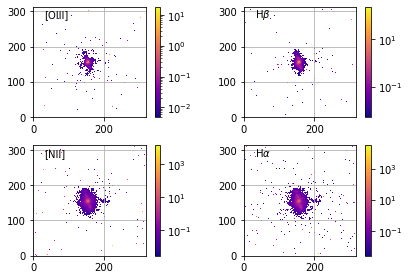

In [177]:
'''What about making BPT ratios?'''

S_N_threshold = 3

gas_select = (Ha_flux / Ha_flux_err > S_N_threshold)

Ha_flux_map = np.full((dim[0],dim[1]) ,np.nan)
Ha_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Ha_flux[gas_select]

gas_select = (OIII5007_flux / OIII5007_flux_err > S_N_threshold)

OIII_flux_map = np.full((dim[0],dim[1]) ,np.nan)
OIII_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = OIII5007_flux[gas_select]


gas_select = (NII6583_flux / NII6583_flux_err > S_N_threshold)

NII_flux_map = np.full((dim[0],dim[1]) ,np.nan)
NII_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = NII6583_flux[gas_select]

gas_select = (Hb_flux / Hb_flux_err > S_N_threshold)

Hb_flux_map = np.full((dim[0],dim[1]) ,np.nan)
Hb_flux_map[eline_y_cor[gas_select],eline_x_cor[gas_select]] = Hb_flux[gas_select]


fig = plt.figure()

ax = fig.add_subplot(221)

ax.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(OIII_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar1 = plt.colorbar()

ax.annotate('[OIII]', xy=(0.1,0.9), xycoords='axes fraction')


ax1 = fig.add_subplot(222)

ax1.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(Hb_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar = plt.colorbar()
ax1.annotate(r'H$\beta$', xy=(0.1,0.9), xycoords='axes fraction')

ax2 = fig.add_subplot(223)

ax2.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(NII_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar2 = plt.colorbar()
#cbar1.set_label(r"[OIII]5007 Flux ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$)")
#ax.set_label('OIII')
ax2.annotate('[NII]', xy=(0.1,0.9), xycoords='axes fraction')


ax3 = fig.add_subplot(224)

ax3.grid('off')


cmap = cm.plasma
cmap.set_bad('white',1) # Make the NANs white

frame = plt.imshow(Ha_flux_map, origin='lower', cmap=cmap, norm=LogNorm(), interpolation='None')
cbar = plt.colorbar()
ax3.annotate(r'H$\alpha$', xy=(0.1,0.9), xycoords='axes fraction')

plt.tight_layout()
plt.show()



[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]]


<Figure size 432x288 with 0 Axes>

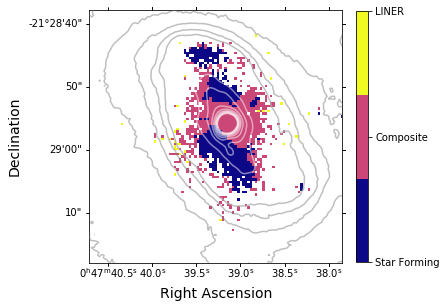

(314, 319)


In [178]:
import math
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
#Kauffmann2003: log([O III]/Hβ) < 0.61/[log([N II]/Hα) − 0.05] + 1.3 divide that marks the limit of SF
xs_kauf = np.linspace(-2,0,100)
ys_kauf = [0.61/(x-0.05) + 1.3 for x in xs_kauf]

#Kewley2001 
#Composite: 0.61/[log([N II]/Hα) − 0.47] + 1.19 > log([O III]/Hβ) divide that marks the limit of composite
xs_kew = np.linspace(-2,0.45,100)
ys_kew = [0.61/(x-0.47) + 1.19 for x in xs_kew]

#From Schawinski to divide LINERS from AGN
#log([OIII]/Hβ) = 1.05 log([NII]/Hα) + 0.45
xs_sch = np.linspace(0,1,100)
ys_sch = [1.05*x + 0.45 for x in xs_sch]

list_NII_Halpha = []
list_OIII_Hbeta = []
color = []
spatial_BPT = np.zeros((np.shape(Ha_flux_map)[0], np.shape(Ha_flux_map)[1]))
for i in range(np.shape(Ha_flux_map)[0]):
    for j in range(np.shape(Ha_flux_map)[1]):
        if np.isnan(OIII_flux_map[i,j]) or np.isnan(Hb_flux_map[i,j]) or np.isnan(NII_flux_map[i,j]) or np.isnan(Ha_flux_map[i,j]):
            continue
        else:
            OIII_Hbeta_ratio = np.log10(OIII_flux_map[i,j]/Hb_flux_map[i,j])
            NII_Halpha_ratio = np.log10(NII_flux_map[i,j]/Ha_flux_map[i,j])
            list_NII_Halpha.append(NII_Halpha_ratio)
            list_OIII_Hbeta.append(OIII_Hbeta_ratio)
            if OIII_Hbeta_ratio > (0.61/(NII_Halpha_ratio-0.47)+1.19):#Then it is either an AGN or LINER or composite
                if OIII_Hbeta_ratio > (1.05*NII_Halpha_ratio + 0.45):
                    spatial_BPT[i,j]=1.25 #AGN
                    color.append(1.25)
                   
                    continue
                else:
                    spatial_BPT[i,j]=1.0 #LINER
                    color.append(1.0)
                    continue
                    
                
            else:
                if OIII_Hbeta_ratio > (0.61/(NII_Halpha_ratio-0.05)+1.3):#Then its a composite
                    
                    
                    spatial_BPT[i,j]=0.75
                    color.append(0.75)
                    continue
                else:#SF
                    spatial_BPT[i,j]=0.5
                    color.append(0.5)
                    
                    continue
            
                    
spatial_BPT_ma = np.ma.masked_where(spatial_BPT==0,spatial_BPT)

print(spatial_BPT_ma)

plt.clf()
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection=wcs)

ax.coords[0].set_axislabel('Right Ascension', fontsize=fontsize)
ax.coords[1].set_axislabel('Declination', fontsize=fontsize)
print(plt.cm.get_cmap('Accent',3))

colorsList = [(126,201,126),(253,192,134),(240,3,126)]
CustomCmap = matplotlib.colors.ListedColormap(colorsList)

im = ax.imshow(spatial_BPT_ma, cmap=plt.cm.get_cmap('plasma', 3))
#plt.colorbar(im)
cbar = plt.colorbar(im, fraction=0.045, ticks=np.linspace(0.5,1,3))
cbar.set_ticklabels(['Star Forming', 'Composite', 'LINER','AGN'])
ax.contour(fovdata, levels=np.linspace(5e-3,1e-1, 10), colors='white', alpha=0.5)
ax.contour(fovdata, levels=np.linspace(1e-3,5e-3, 5), colors='gray', alpha=0.5)
ax.set_xlim([100,200])
ax.set_ylim([100,200])
plt.show()

print(np.shape(spatial_BPT_ma))

()


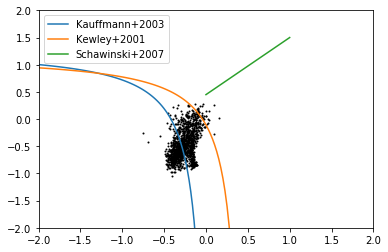

In [179]:
plt.clf()
print(np.shape(NII_Halpha_ratio))
plt.scatter(list_NII_Halpha, list_OIII_Hbeta, color='black', s=1)#, color=color, cmap=plt.cm.get_cmap('plasma', 4))
plt.plot(xs_kauf, ys_kauf, label='Kauffmann+2003')
plt.plot(xs_kew, ys_kew, label='Kewley+2001')
plt.plot(xs_sch, ys_sch, label='Schawinski+2007')
plt.legend()
plt.ylim([-2,2])
plt.xlim([-2,2])
plt.show()